In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm




def monte_carlo(ticker,prediction_days,number_simulations):
    end_date=datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))


    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day


    threshold2 = 30 #144 #116
    threshold1 = 150 #162 #128

    #Volatility for BSM
    volatility_bsm = 0.26   # Assuming 29% annualized volatility was 0.072

    print("BMS Implied Volatility: ", volatility_bsm)


    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        
        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                        scale=volatility * np.sqrt(dt),
                                        size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_historical = run_simulation(log_returns.std(), dt)
    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    print("Historical Volatility: ", log_returns.std())


    fig, axs = plt.subplots(1, 2, figsize=(30, 7))

    for simulated_prices, ax, title in zip([simulated_prices_historical, simulated_prices_bsm], axs, ['Historical Volatility', 'BSM Volatility']):
        mean_price_path = np.mean(simulated_prices, axis=1)
        median_price_path = np.median(simulated_prices, axis=1)
        lower_bound_68 = np.percentile(simulated_prices, 16, axis=1)
        upper_bound_68 = np.percentile(simulated_prices, 84, axis=1)
        lower_bound_95 = np.percentile(simulated_prices, 2.5, axis=1)
        upper_bound_95 = np.percentile(simulated_prices, 97.5, axis=1)

        
        threshold1 = threshold1
        threshold2 = threshold2

        ax.plot(simulated_prices, color='lightgray', alpha=0.1)
        ax.plot(mean_price_path, color='black', label='Mean Price Path')
        ax.plot(median_price_path, color='blue', label='Median Price Path')
        ax.plot(lower_bound_68, color='green', linestyle='--', label='68% confidence interval (Lower)')
        ax.plot(upper_bound_68, color='green', linestyle='--', label='68% confidence interval (Upper)')
        ax.plot(lower_bound_95, color='blue', linestyle='--', label='95% confidence interval (Lower)')
        ax.plot(upper_bound_95, color='red', linestyle='--', label='95% confidence interval (Upper)')

        ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.25, label='Threshold 1')
        ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.25, label='Threshold 2')

        
        ax.set_xlabel('Days')
        ax.set_ylabel('Stock Price')
        ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using {title}', fontsize = 25)
        ax.legend(fontsize = 15)

        #price estimates every 5 days
        for day in range(0, days_to_forecast, 20):
            ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='green')
            ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='green')
            ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='blue')
            ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='red')

    
        above_threshold1_prob = (simulated_prices[-1] > threshold1).sum() / num_simulations
        below_threshold2_prob = (simulated_prices[-1] < threshold2).sum() / num_simulations
        between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
                transform=ax.transAxes, fontsize=15,
                verticalalignment='bottom', bbox=props)
        
        
        #ax.annotate(f'{mean_price_path[-1]:.2f}', xy=(days_to_forecast - 1, mean_price_path[-1]), xycoords='data',
        #            xytext=(15, 0), textcoords='offset points', color='black')

        
        ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                    xytext=(15, 0), textcoords='offset points', color='blue')
        
        
        ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='green')
        ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='green')
        ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='blue')
        ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='red')

    plt.show()



[*********************100%%**********************]  1 of 1 completed


BMS Implied Volatility:  0.26
Historical Volatility:  0.014178563846459104


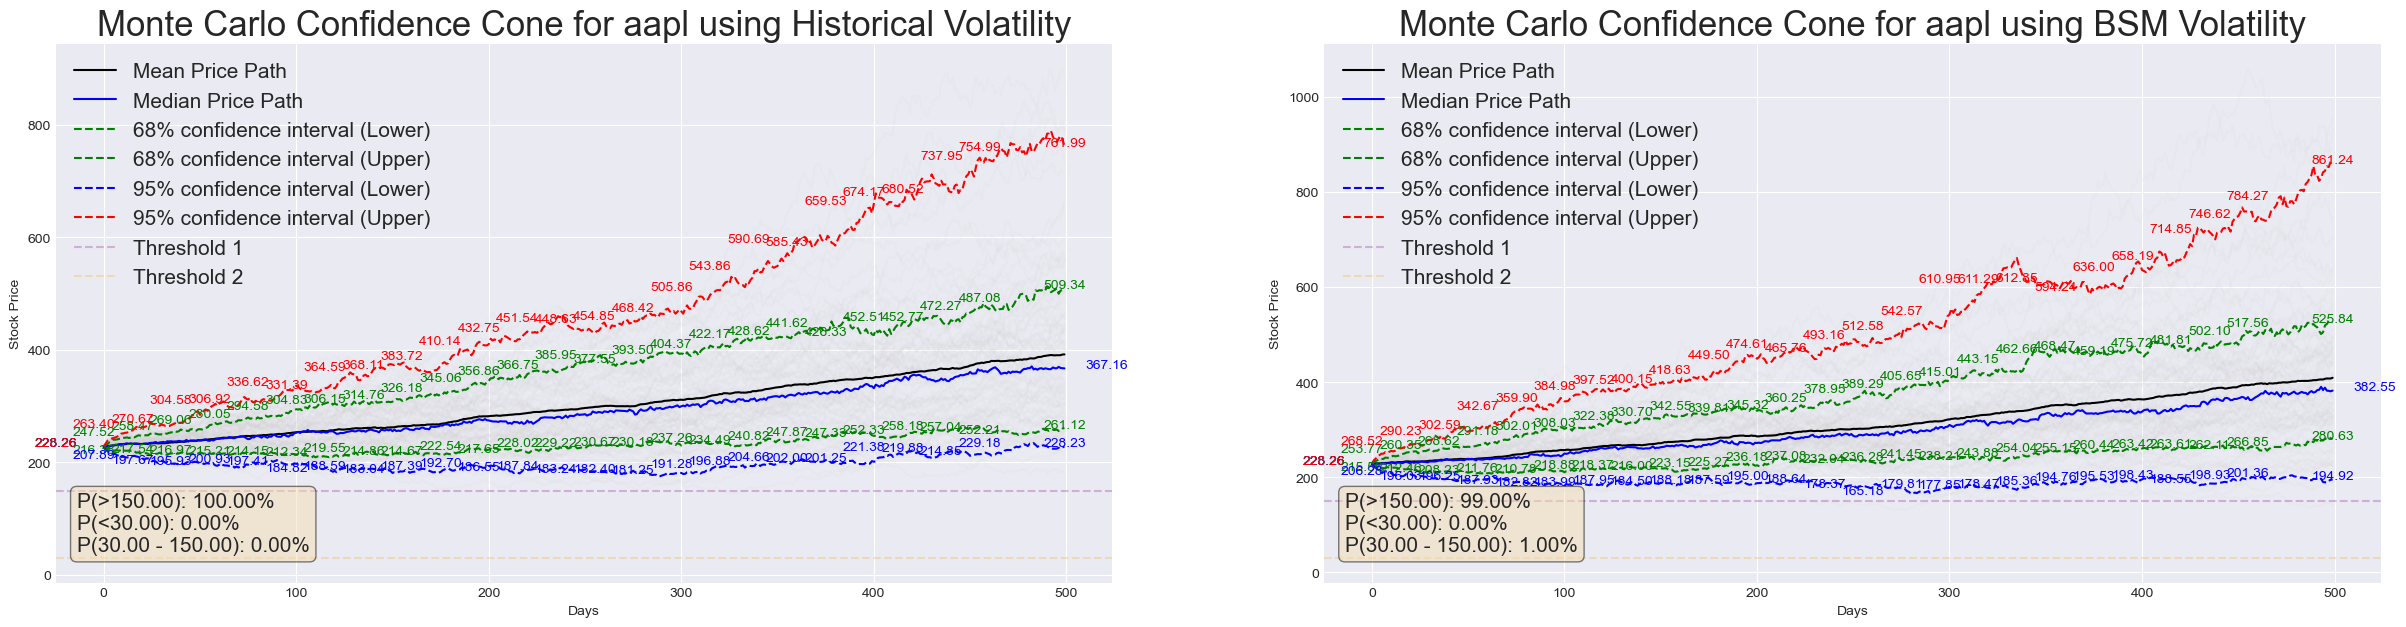

In [6]:

monte_carlo('aapl',500,100)

[*********************100%%**********************]  1 of 1 completed


BMS Implied Volatility:  0.26
Historical Volatility:  0.01417831819497293


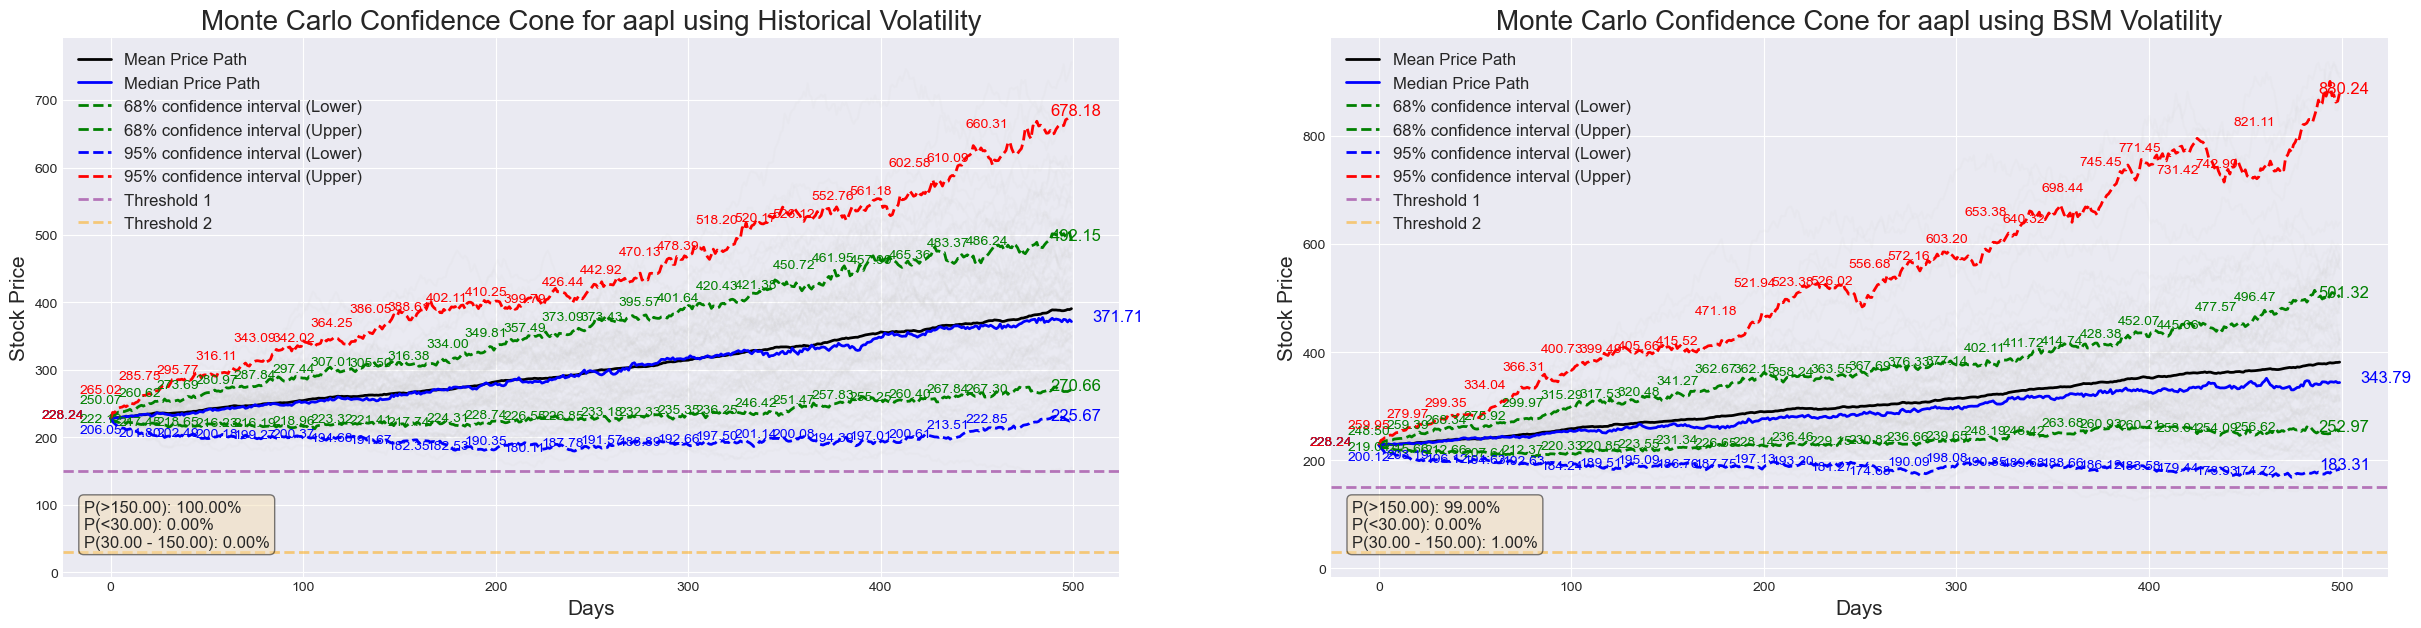

In [4]:

monte_carlo('aapl',500,100)

In [3]:
  import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Set the style for the plots
plt.style.use('seaborn-darkgrid')  # You can change this to any other style you prefer

def monte_carlo(ticker, prediction_days, number_simulations):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))

    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day

    threshold2 = 30
    threshold1 = 150

    # Volatility for BSM
    volatility_bsm = 0.26  # Assuming 29% annualized volatility

    print("BMS Implied Volatility: ", volatility_bsm)

    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_historical = run_simulation(log_returns.std(), dt)
    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    print("Historical Volatility: ", log_returns.std())

    fig, axs = plt.subplots(1, 2, figsize=(30, 7))

    for simulated_prices, ax, title in zip([simulated_prices_historical, simulated_prices_bsm], axs, ['Historical Volatility', 'BSM Volatility']):
        mean_price_path = np.mean(simulated_prices, axis=1)
        median_price_path = np.median(simulated_prices, axis=1)
        lower_bound_68 = np.percentile(simulated_prices, 16, axis=1)
        upper_bound_68 = np.percentile(simulated_prices, 84, axis=1)
        lower_bound_95 = np.percentile(simulated_prices, 2.5, axis=1)
        upper_bound_95 = np.percentile(simulated_prices, 97.5, axis=1)

        ax.plot(simulated_prices, color='lightgray', alpha=0.1)
        ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2)
        ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)
        ax.plot(lower_bound_68, color='green', linestyle='--', label='68% confidence interval (Lower)', linewidth=2)
        ax.plot(upper_bound_68, color='green', linestyle='--', label='68% confidence interval (Upper)', linewidth=2)
        ax.plot(lower_bound_95, color='blue', linestyle='--', label='95% confidence interval (Lower)', linewidth=2)
        ax.plot(upper_bound_95, color='red', linestyle='--', label='95% confidence interval (Upper)', linewidth=2)

        ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
        ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)

        ax.set_xlabel('Days', fontsize=15)
        ax.set_ylabel('Stock Price', fontsize=15)
        ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using {title}', fontsize=20)
        ax.legend(fontsize=12)

        # Price estimates every 20 days
        for day in range(0, days_to_forecast, 20):
            ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
            ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
            ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='blue', fontsize=10)
            ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                        xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

        above_threshold1_prob = (simulated_prices[-1] > threshold1).sum() / num_simulations
        below_threshold2_prob = (simulated_prices[-1] < threshold2).sum() / num_simulations
        between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                            f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                            f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
                transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom', bbox=props)

        ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                    xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
        ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
        ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
        ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='blue', fontsize=12)
        ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)

    plt.show()

/var/folders/mk/fn7b709x3dz4m442ngj1_xf00000gn/T/ipykernel_24132/172794421.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # You can change this to any other style you prefer


/var/folders/mk/fn7b709x3dz4m442ngj1_xf00000gn/T/ipykernel_24132/1975738679.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # You can change this to any other style you prefer
[*********************100%%**********************]  1 of 1 completed


BSM Implied Volatility:  0.26


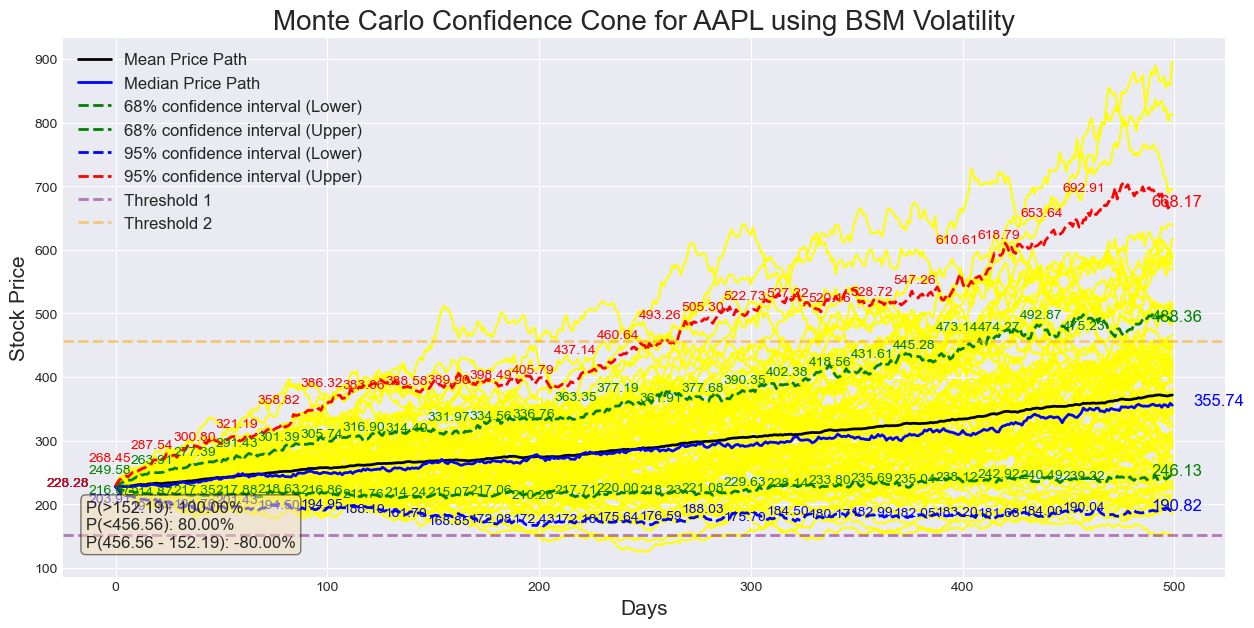

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Set the style for the plots
plt.style.use('seaborn-darkgrid')  # You can change this to any other style you prefer

def monte_carlo(ticker, prediction_days, number_simulations):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))

    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day

    threshold2 = df['Adj Close'][-1]*2
    threshold1 = df['Adj Close'][-1]/1.5

    # Volatility for BSM
    volatility_bsm = 0.26  # Assuming 26% annualized volatility

    print("BSM Implied Volatility: ", volatility_bsm)

    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    fig, ax = plt.subplots(figsize=(15, 7))

    mean_price_path = np.mean(simulated_prices_bsm, axis=1)
    median_price_path = np.median(simulated_prices_bsm, axis=1)
    lower_bound_68 = np.percentile(simulated_prices_bsm, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices_bsm, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices_bsm, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices_bsm, 97.5, axis=1)

    # Plot the chaotic lines with more prominence
    ax.plot(simulated_prices_bsm, color='yellow') #alpha=0.6, linewidth=1)

    ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2)
    ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)
    ax.plot(lower_bound_68, color='green', linestyle='--', label='68% confidence interval (Lower)', linewidth=2)
    ax.plot(upper_bound_68, color='green', linestyle='--', label='68% confidence interval (Upper)', linewidth=2)
    ax.plot(lower_bound_95, color='blue', linestyle='--', label='95% confidence interval (Lower)', linewidth=2)
    ax.plot(upper_bound_95, color='red', linestyle='--', label='95% confidence interval (Upper)', linewidth=2)

    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)

    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Stock Price', fontsize=15)
    ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using BSM Volatility', fontsize=20)
    ax.legend(fontsize=12)

    # Price estimates every 20 days
    for day in range(0, days_to_forecast, 20):
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='blue', fontsize=10)
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

    above_threshold1_prob = (simulated_prices_bsm[-1] > threshold1).sum() / num_simulations
    below_threshold2_prob = (simulated_prices_bsm[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)

    plt.show()

# Run the Monte Carlo simulation with the specified parameters
monte_carlo('AAPL', 500, 100)

[*********************100%%**********************]  1 of 1 completed


BSM Implied Volatility:  0.26


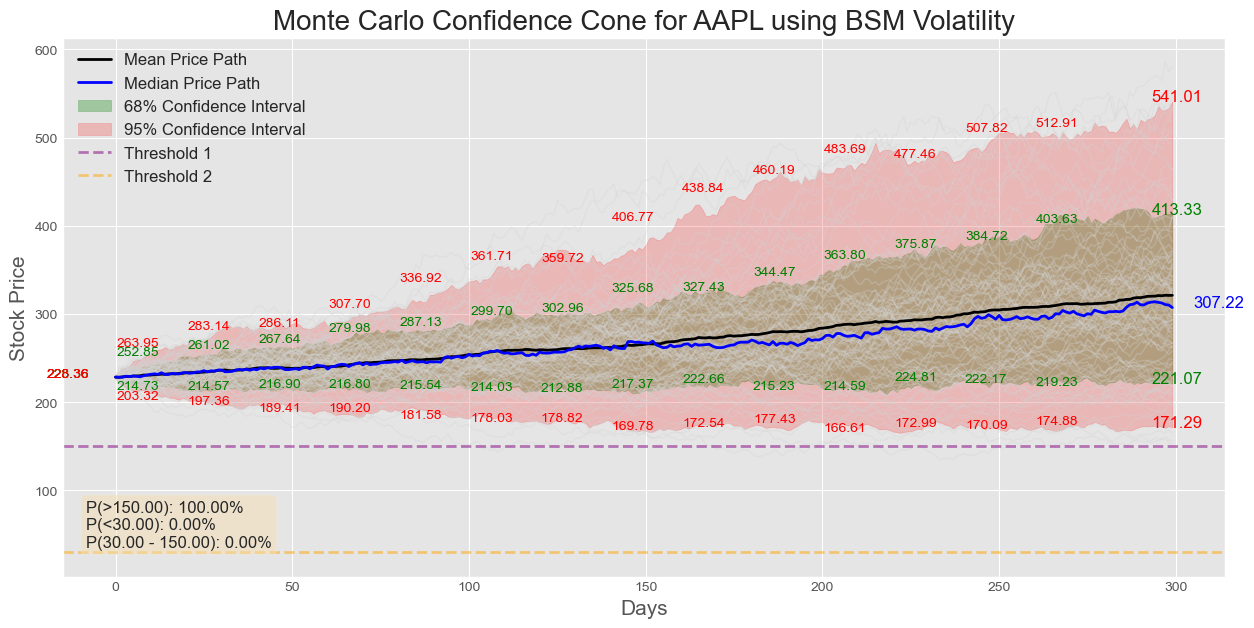

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Set the style for the plots
plt.style.use('ggplot')  # Change to a different style for a modern look

def monte_carlo(ticker, prediction_days, number_simulations):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))

    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day

    threshold2 = 30
    threshold1 = 150

    # Volatility for BSM
    volatility_bsm = 0.26  # Assuming 26% annualized volatility

    print("BSM Implied Volatility: ", volatility_bsm)

    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    fig, ax = plt.subplots(figsize=(15, 7))

    mean_price_path = np.mean(simulated_prices_bsm, axis=1)
    median_price_path = np.median(simulated_prices_bsm, axis=1)
    lower_bound_68 = np.percentile(simulated_prices_bsm, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices_bsm, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices_bsm, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices_bsm, 97.5, axis=1)

    # Plot the chaotic lines with more prominence
    ax.plot(simulated_prices_bsm, color='lightgray', alpha=0.3, linewidth=1)

    # Plot the mean and median price paths
    ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2)
    ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)

    # Plot the confidence intervals as shaded areas
    ax.fill_between(range(days_to_forecast), lower_bound_68, upper_bound_68, color='green', alpha=0.3, label='68% Confidence Interval')
    ax.fill_between(range(days_to_forecast), lower_bound_95, upper_bound_95, color='red', alpha=0.2, label='95% Confidence Interval')

    # Plot the thresholds
    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)

    # Set labels and title
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Stock Price', fontsize=15)
    ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using BSM Volatility', fontsize=20)
    ax.legend(fontsize=12)

    # Price estimates every 20 days
    for day in range(0, days_to_forecast, 20):
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

    above_threshold1_prob = (simulated_prices_bsm[-1] > threshold1).sum() / num_simulations
    below_threshold2_prob = (simulated_prices_bsm[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)

    plt.show()

# Run the Monte Carlo simulation with the specified parameters
monte_carlo('AAPL', 300, 100)

[*********************100%%**********************]  1 of 1 completed


BSM Implied Volatility:  0.26


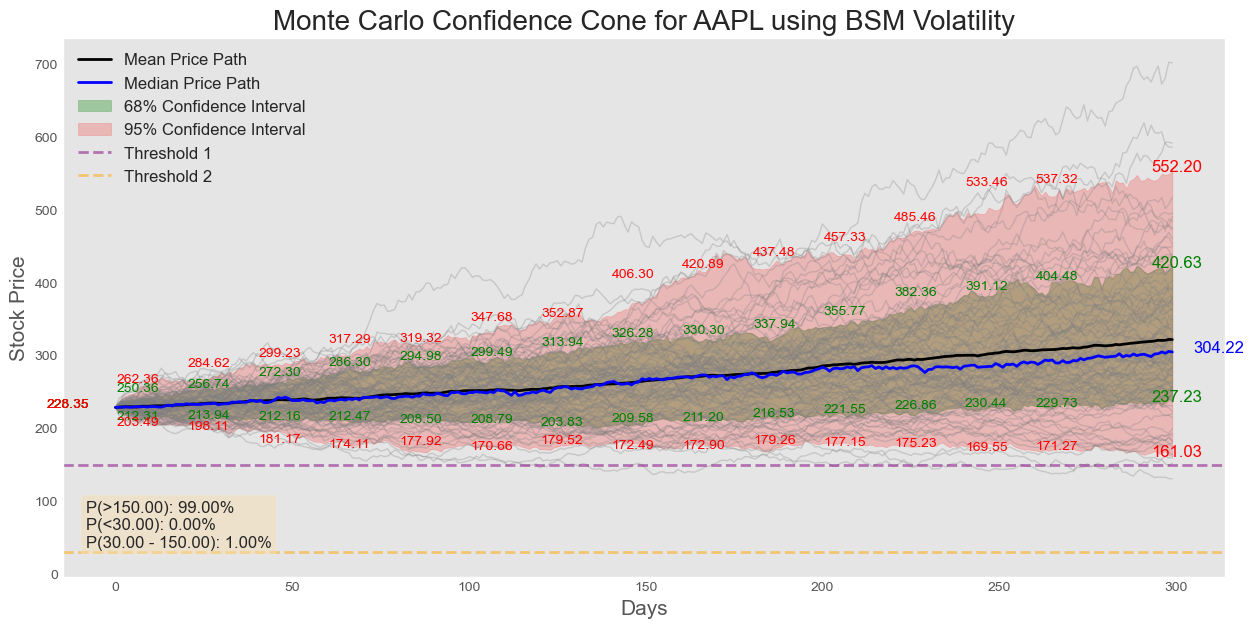

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Set the style for the plots
plt.style.use('ggplot')  # Change to a different style for a modern look

def monte_carlo(ticker, prediction_days, number_simulations):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))

    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day

    threshold2 = 30
    threshold1 = 150

    # Volatility for BSM
    volatility_bsm = 0.26  # Assuming 26% annualized volatility

    print("BSM Implied Volatility: ", volatility_bsm)

    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    fig, ax = plt.subplots(figsize=(15, 7))

    mean_price_path = np.mean(simulated_prices_bsm, axis=1)
    median_price_path = np.median(simulated_prices_bsm, axis=1)
    lower_bound_68 = np.percentile(simulated_prices_bsm, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices_bsm, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices_bsm, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices_bsm, 97.5, axis=1)

    # Plot the chaotic lines with more prominence
    ax.plot(simulated_prices_bsm, color='gray', alpha=0.3, linewidth=1)

    # Plot the mean and median price paths
    ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2)
    ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)

    # Plot the confidence intervals as shaded areas
    ax.fill_between(range(days_to_forecast), lower_bound_68, upper_bound_68, color='green', alpha=0.3, label='68% Confidence Interval')
    ax.fill_between(range(days_to_forecast), lower_bound_95, upper_bound_95, color='red', alpha=0.2, label='95% Confidence Interval')

    # Plot the thresholds
    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)

    # Set labels and title
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Stock Price', fontsize=15)
    ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using BSM Volatility', fontsize=20)
    ax.legend(fontsize=12)

    # Remove the grid
    ax.grid(False)

    # Price estimates every 20 days
    for day in range(0, days_to_forecast, 20):
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

    above_threshold1_prob = (simulated_prices_bsm[-1] > threshold1).sum() / num_simulations
    below_threshold2_prob = (simulated_prices_bsm[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)

    plt.show()

# Run the Monte Carlo simulation with the specified parameters
monte_carlo('AAPL', 300, 100)